<a href="https://colab.research.google.com/github/ndungek/Threads-Reviews-Sentiment-Analysis/blob/main/reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **THREADS REVIEWS SENTIMENT ANALYSIS:**


---


*Maureen Kitang'a*

## Abstract
In the bustling world of social media and messaging apps, Threads emerges as a fresh contender, stepping into the limelight in July. As it embarks on its journey in the ever-evolving landscape, we set out to decipher the sentiments of Threads app users through a comprehensive sentiment analysis project.

With a relatively small training dataset consisting of just over 5900 examples, we faced the challenge of skewed data. However, our goal was clear: predict sentiment – be it positive, negative, or neutral – with precision and insight.

In [130]:
#importing libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import FreqDist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [131]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
import os

folder_path = '/content/drive/My Drive/Threads-Reviews-Sentiment-Analysis'
os.chdir(folder_path)

In [133]:
folder_contents = os.listdir()
print(folder_contents)

['threads_reviews.csv', 'README.md', 'LICENSE', '.git']


In [134]:
df = pd.read_csv("threads_reviews.csv")

df.head()

,source,review_description,rating,review_date
0,Google Play,Very good app for Android phone and me,5,27-08-2023 10:31
1,Google Play,Sl👍👍👍👍,5,27-08-2023 10:28
2,Google Play,Best app,5,27-08-2023 9:47
3,Google Play,Gatiya app,1,27-08-2023 9:13
4,Google Play,Lit bruv,5,27-08-2023 9:00


In [135]:
def df_shape(df, ds_name):
    print(f"The {ds_name} dataset has {df.shape[0]} rows and {df.shape[1]}")

df_shape(df, "Threads Reviews")

The Threads Reviews dataset has 40435 rows and 4


In [136]:
def df_info(df, ds_name):
    print(f"The {ds_name} dataset info:\n")
    print(df.info())

df_info(df, "Threads Reviews")

The Threads Reviews dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40435 entries, 0 to 40434
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              40435 non-null  object
 1   review_description  40435 non-null  object
 2   rating              40435 non-null  int64 
 3   review_date         40435 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB
None


In [137]:
def check_missing(df, ds_name):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_missing(df, "Threads Reviews")

Null Values in each col in the Threads Reviews dataset:

source                0
review_description    0
rating                0
review_date           0
dtype: int64


In [138]:
def check_duplicates(df, ds_name):
    print(f"Duplicate Values in each col in the {ds_name} dataset:\n")
    print(df.duplicated().sum())

check_duplicates(df, "Threads Reviews")

Duplicate Values in each col in the Threads Reviews dataset:

95


In [139]:
# handling the duplicates
def remove_duplicated_rows(data):
    """Simple Function to remove duplicated rows"""
    data.drop_duplicates(subset=None, keep="first", inplace=True)
    return data


df = remove_duplicated_rows(df)

In [140]:
#Display Unique val in each col
def uni_vals(df, ds_name):
    print(f"The number of unique values in each column in {ds_name} dataset:\n")
    print(df.nunique())

uni_vals(df, "Threads Reviews")

The number of unique values in each column in Threads Reviews dataset:

source                    2
review_description    32894
rating                    5
review_date           16742
dtype: int64


In [141]:
# changing data type of review_date
df['review_date'] = pd.to_datetime(df['review_date'])
df['review_date'].dtype

dtype('<M8[ns]')

In [142]:
# Create new 'date' and 'time' columns
df['review_dates'] = df['review_date'].dt.date
df['review_time'] = df['review_date'].dt.time

# Drop the original 'review_date' column
df.drop(columns=['review_date'], inplace=True)
df.head()

,source,review_description,rating,review_dates,review_time
0,Google Play,Very good app for Android phone and me,5,2023-08-27,10:31:00
1,Google Play,Sl👍👍👍👍,5,2023-08-27,10:28:00
2,Google Play,Best app,5,2023-08-27,09:47:00
3,Google Play,Gatiya app,1,2023-08-27,09:13:00
4,Google Play,Lit bruv,5,2023-08-27,09:00:00


In [143]:
df["source"].value_counts()

Google Play    36628
App Store       3712
Name: source, dtype: int64

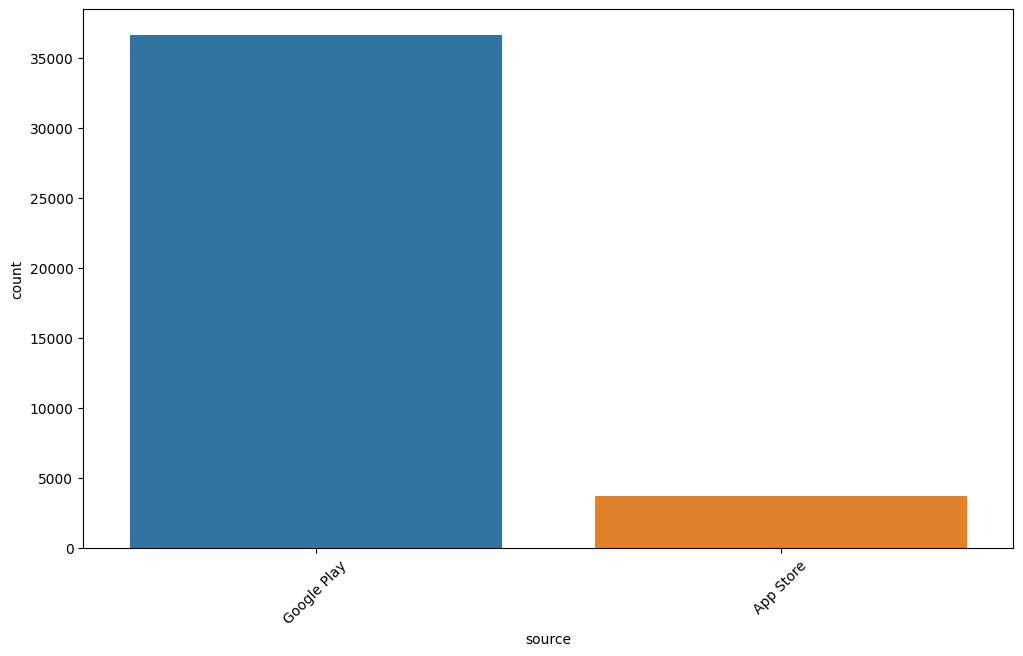

In [144]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='source')
plt.xticks(rotation=45)
plt.show()

In [145]:
df['rating'] = df['rating'].astype('int32')

In [146]:
df['rating'] = df['rating'].replace([1,2], 'bad')
df['rating'] = df['rating'].replace(3, 'neutral')
df['rating'] = df['rating'].replace([4,5], 'good')

In [147]:
df['rating'].value_counts()

good       21954
bad        15211
neutral     3175
Name: rating, dtype: int64

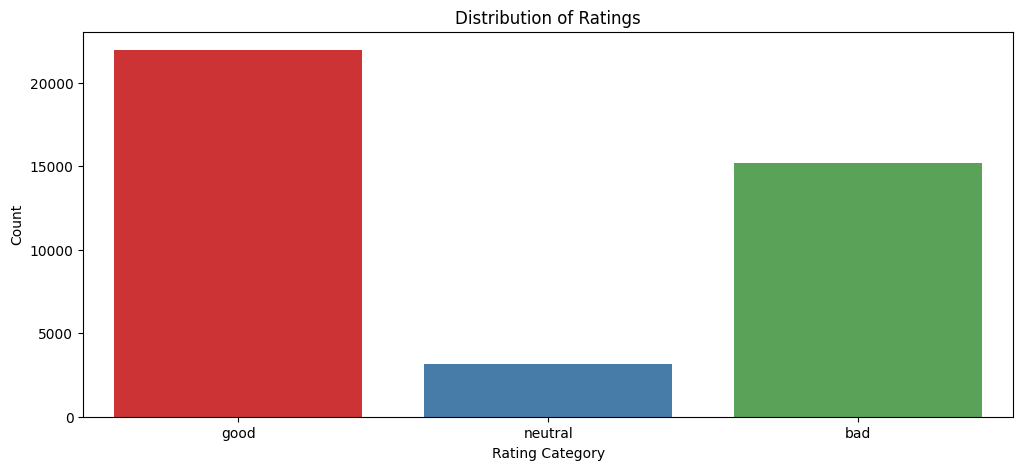

In [148]:
# Calculate the counts of each rating category
rating_counts = df['rating'].value_counts()

# Calculate the percentages
total_ratings = rating_counts.sum()
percentages = (rating_counts / total_ratings) * 100

# Create a countplot
plt.figure(figsize=(12, 5))
plot = sns.countplot(data=df, x='rating', order=['good', 'neutral', 'bad'], palette='Set1')

# Set labels and title
plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.title('Distribution of Ratings')

# Show the plot
plt.show()

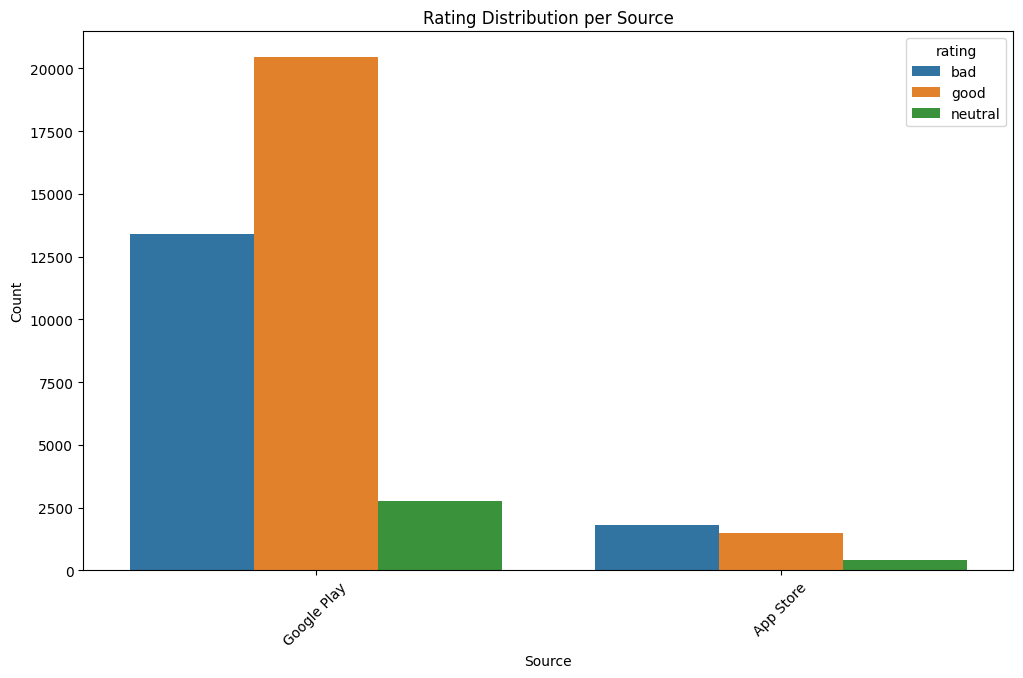

In [152]:
# Group by 'source' and 'emotion' columns to get sentiment counts per source
source_sentiment_group = df.groupby(['source', 'rating'])['rating'].count().reset_index(name='count')

# Calculate the ascending order of sources based on total review count
ascending_order = df['source'].value_counts().index

# Create a bar plot for sentiment distribution per source
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='source', y='count', hue='rating', data=source_sentiment_group, order=ascending_order)
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Rating Distribution per Source')
plt.xticks(rotation=45)
plt.show()


## Data PreProcessing

>> Text data often contains special characters and uppercase letters, which can lead to inconsistencies during analysis. Cleaning the text involves removing special characters and converting text to lowercase for consistency.

In [ ]:
# Define a function to clean text by removing special characters and converting to lowercase
def clean_text(text):
    # Remove special characters and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

# Apply the clean_text function to the 'review_description' column
df['cleaned_review_description'] = df['review_description'].apply(clean_text)

>> Tokenization breaks text into individual words or tokens. It's a necessary step for text analysis, as it allows us to work with individual words.

In [ ]:
# Define a function for tokenization (splitting text into words)
def tokenize_text(text):
    return word_tokenize(text)

# Apply tokenization to the 'cleaned_review_description' column
df['tokens'] = df['cleaned_review_description'].apply(tokenize_text)


>>  Stopwords are common words (e.g., "the," "and," "is") that don't usually contribute much to the analysis. Removing them reduces noise in the data.

In [ ]:
# Get a set of English stopwords
stop_words = set(stopwords.words('english'))

# Define a function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Apply stopword removal to the 'tokens' column
df['cleaned_tokens'] = df['tokens'].apply(remove_stopwords)

>> Lemmatization reduces words to their base or root form. It ensures that words like "running" and "ran" are treated as the same word ("run"), improving the consistency of the data.

In [ ]:
# Initialize a WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function for lemmatization
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply lemmatization to the 'cleaned_tokens' column
df['lemmatized_tokens'] = df['cleaned_tokens'].apply(lemmatize_tokens)

>> Text data needs to be converted into numerical form for machine learning models. TF-IDF vectorization converts text data into numerical vectors while capturing the importance of words in the text. It results in a feature matrix that can be used for analysis and modeling.

In [ ]:
# Initialize a TF-IDF vectorizer with a maximum of 1000 features (adjust as needed)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Transform the 'lemmatized_tokens' into TF-IDF features
tfidf_matrix = tfidf_vectorizer.fit_transform(df['lemmatized_tokens'].apply(lambda x: ' '.join(x)))

# Convert the TF-IDF matrix to a DataFrame with feature names
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Merge the TF-IDF features with the original DataFrame
df = pd.concat([df, tfidf_df], axis=1)

In [ ]:
# Calculate text lengths (number of words) and add as a new column
df['text_length'] = df['cleaned_tokens'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Visualize the distribution of text lengthS
import plotly.express as px

# Create a histogram of text lengths using Plotly
fig = px.histogram(df, x='text_length', nbins=20, labels={'text_length': 'Text Length (Number of Words)'})
fig.update_layout(
    title='Distribution of Text Lengths',
    xaxis_title='Text Length (Number of Words)',
    yaxis_title='Frequency'
)

# Show the Plotly figure
fig.show()

> Named Entity Recognition (NER):

Implement Named Entity Recognition to identify and extract entities (e.g., names of places, organizations, people) from the reviews. This can provide insights into what entities are frequently mentioned in the reviews.

In [ ]:
import spacy

# Load the spaCy NER model
nlp = spacy.load('en_core_web_sm')

# Define a function to perform NER on text
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply NER to a sample review
sample_review = df['review_description'].iloc[0]
entities = extract_entities(sample_review)
print(entities)

> Exploring Bi-grams and Tri-grams:

Analyze and visualize the most common bi-grams (two-word combinations) and tri-grams (three-word combinations) in the reviews. This can provide insights into phrases that are frequently used.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px

# Replace NaN values in the 'cleaned_review_description' column with empty strings
df['cleaned_review_description'].fillna('', inplace=True)

# Initialize a CountVectorizer for bi-grams and tri-grams
bi_tri_gram_vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=20)

# Fit and transform the text data to extract bi-grams and tri-grams
bi_tri_grams = bi_tri_gram_vectorizer.fit_transform(df['cleaned_review_description'])

# Get feature names (bi-grams and tri-grams)
feature_names = bi_tri_gram_vectorizer.get_feature_names_out()

# Calculate the sum of frequencies for each bi-gram and tri-gram
bi_tri_gram_frequencies = bi_tri_grams.sum(axis=0).tolist()[0]

# Create a DataFrame for plotting
bi_tri_gram_df = pd.DataFrame({'Feature Names': feature_names, 'Frequency': bi_tri_gram_frequencies})

# Sort the DataFrame by frequency in descending order
bi_tri_gram_df = bi_tri_gram_df.sort_values(by='Frequency', ascending=False)

# Create a bar chart using Plotly
fig = px.bar(bi_tri_gram_df, x='Feature Names', y='Frequency',
             labels={'Feature Names': 'Bi-grams and Tri-grams', 'Frequency': 'Frequency'},
             title='Top Bi-grams and Tri-grams in Reviews', height=400)

fig.update_xaxes(tickangle=45)  # Rotate x-axis labels for better readability

# Show the Plotly figure
fig.show()

> Sentiment Lexicon Analysis:

Explore sentiment lexicons (lists of words with associated sentiment scores) and analyze how the sentiment scores of individual words contribute to the overall sentiment of reviews.

In [ ]:
# Calculate the overall sentiment score of each review based on the lexicon
df['sentiment_score'] = df['cleaned_tokens'].apply(lambda tokens: sum(sentiment_lexicon.get(word, 0) for word in tokens)
                                                  if isinstance(tokens, list) else np.nan)

# Visualize the distribution of sentiment scores
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='sentiment_score', bins=20)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()
